In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# Importing required modules

import os
import math
import feather

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

import re

### Helper functions

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    '''Helper function to fix missing values, replace categorical variables with their category codes
       and create one-hot-encoded variables'''
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1
        
def train_cats(df):
    '''Helper function to change string type variables to category type'''
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
            
def apply_cats(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)
            
def add_datepart(df, field_name, prefix=None, drop=True, time=False):
    '''Helper function that adds columns relevant to a date in the column `field_name` of `df`'''
    field = df[field_name]
    prefix = re.sub('[Dd]ate$', '', field_name) if prefix is None else prefix
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[prefix + n] = getattr(field.dt, n.lower())
    df[prefix + 'Elapsed'] = field.astype(np.int64) // 10 ** 11
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [4]:
data_raw = pd.read_csv('Bullzoders_Train.csv', low_memory=False, parse_dates=['saledate'])

In [5]:
data_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data_raw.shape

(401125, 53)

In [7]:
add_datepart(data_raw, 'saledate')
data_raw.shape

(401125, 65)

The `train_cats` function changes the string type variables to category type variables

In [8]:
train_cats(data_raw)

In [9]:
data_raw['SalePrice'] = np.log(data_raw['SalePrice'])

The `proc_df` function does all the rest of the pre-processing required. It fills the missing values with the column median, replaces the categorical variables by their category codes, creates one-hot-encoded variables and created a new column for every column that contains missing values, the new column contains a binary variable which is equal to 0 if the original column has no missing value in that row, and 1 if the original column has a missing value 

In [10]:
X, y, nas = proc_df(data_raw, 'SalePrice', max_n_cat=7)

In [11]:
n_valid = 12000 
'''I chose the size of validation set as 12000 as it is equal to the size of kaggle test set'''
n_trn = len(X)-n_valid
raw_train, raw_valid = split_vals(data_raw, n_trn)
X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)
'''Didn't use random splits for creating a validation test split since the rows are arranged by 
   date, so random split would get the training set to contain rows from the most recent auctions
   too, which would allow the model to predict the validation set too easily due to look-ahead bias'''

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((389125, 173), (389125,), (12000, 173), (12000,))

In [12]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 7min 24s, sys: 4.73 s, total: 7min 29s
Wall time: 1min 15s
[0.12002393964544845, 0.23320593699717324, 0.9698927851460575, 0.9028758616035542, 0.9103512979641954]


In [13]:
fi = rf_feat_importance(m, X); fi[:50]

,cols,imp
67,Enclosure_EROPS w AC,0.162075
5,YearMade,0.139848
48,ProductGroup_SSL,0.089639
2,ModelID,0.060856
12,fiProductClassDesc,0.059383
32,saleElapsed,0.050342
55,ProductGroupDesc_Skid Steer Loaders,0.046631
43,ProductSize_Mini,0.042095
9,fiSecondaryDesc,0.037628
7,fiModelDesc,0.028546


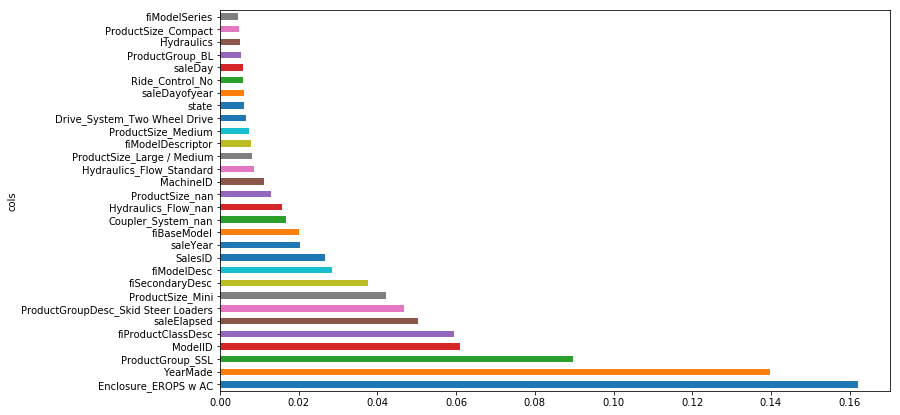

In [14]:
plot_fi(fi[:30])

Only those columns with a feature importance greater than `0.005` are retained

In [15]:
imp_col = fi[fi.imp>0.005].cols; len(imp_col)

27

In [16]:
X_imp_col = X[imp_col].copy()
X_train, X_valid = split_vals(X_imp_col, n_trn)

In [17]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12664157152827707, 0.2332401674684438, 0.966481281327036, 0.9028473473292761, 0.9078768636212764]


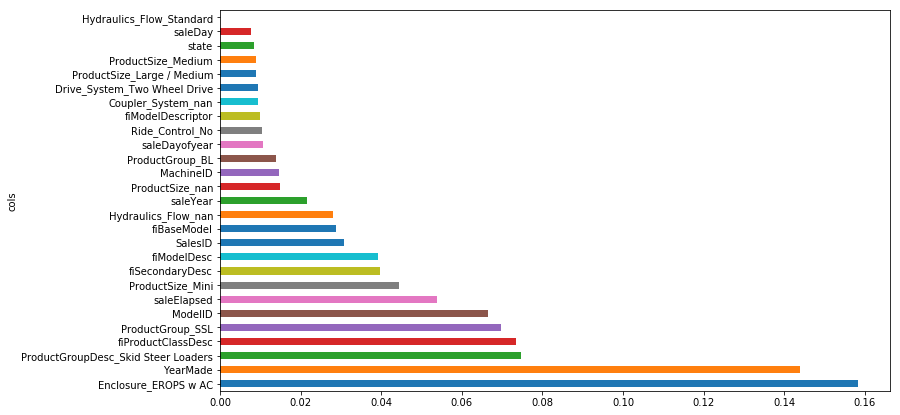

In [18]:
fi = rf_feat_importance(m, X_imp_col)
plot_fi(fi);

Next, I use a dendogram to find out which features are essentially redundant

In [19]:
from scipy.cluster import hierarchy as hc
import scipy

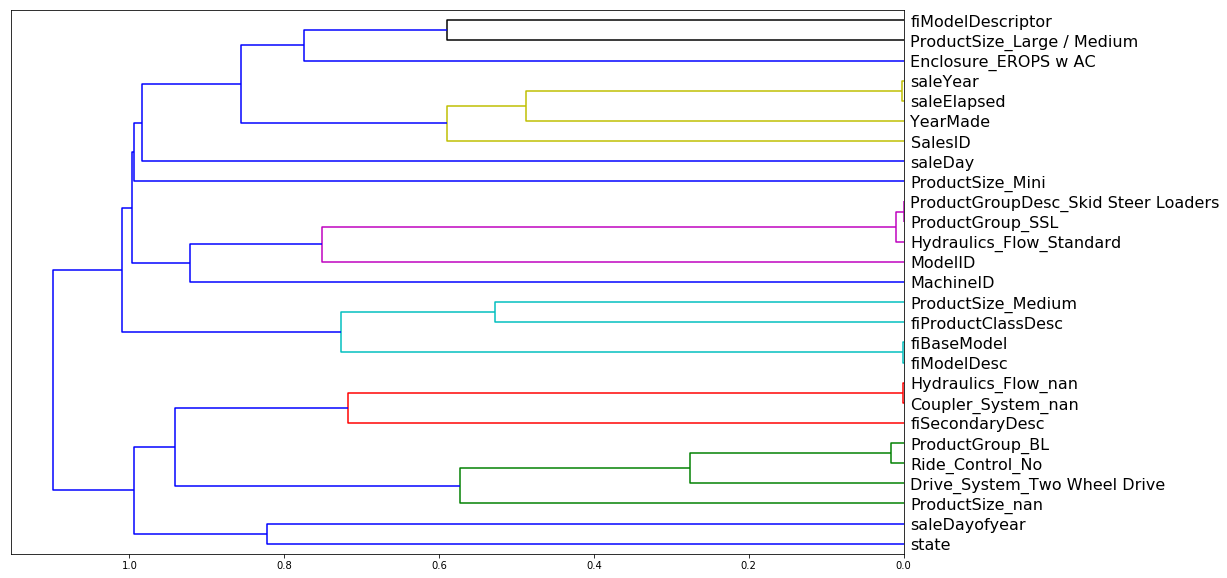

In [20]:
corr = np.round(scipy.stats.spearmanr(X_imp_col).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_imp_col.columns, orientation='left', leaf_font_size=16)
plt.show()

In [21]:
get_oob(X_imp_col)

0.9038010493966182

From the dendogram we see that there are three set of features in each of which two features are completely correlated. Next I remove one feature at a time from each group and see how removing them affects the OOB Score

In [22]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 
          'ProductGroup_SSL', 'ProductGroupDesc_Skid Steer Loaders', 'Hydraulics_Flow_nan', 'Coupler_System_nan'):
    print(c, get_oob(X_imp_col.drop(c, axis=1)))

saleYear 0.9036904668844291
saleElapsed 0.9022309566562491
fiModelDesc 0.9033963235759008
fiBaseModel 0.9034062416579466
ProductGroup_SSL 0.9043028184414799
ProductGroupDesc_Skid Steer Loaders 0.904362703831833
Hydraulics_Flow_nan 0.9043543650317718
Coupler_System_nan 0.9039736239669387


In [23]:
to_drop = ['saleYear', 'fiBaseModel', 'ProductGroup_SSL', 'Hydraulics_Flow_nan']
get_oob(X_imp_col.drop(to_drop, axis=1))

/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.9026784551655078

In [24]:
X_imp_col.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(X_imp_col, n_trn)

In [25]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12768499323615, 0.23511289891254086, 0.9659266729576582, 0.9012809683563533, 0.9066681330536565]


After further analysis of pairs of features, it's seen that a lot of values of YearMade of bulldozers is 1000, which isn't possible. So I set the value of YearMade to 1950 for the years it was 1000 to gete reliable values for a new feature I created `Age = SaleYear - YearMade`

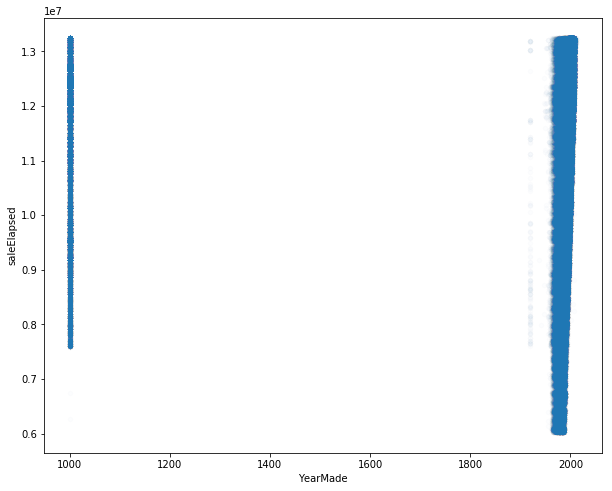

In [26]:
X_imp_col.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [27]:
data_raw.YearMade[data_raw.YearMade<1950] = 1950
X_imp_col['age'] = data_raw['age'] = data_raw.saleYear-data_raw.YearMade

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


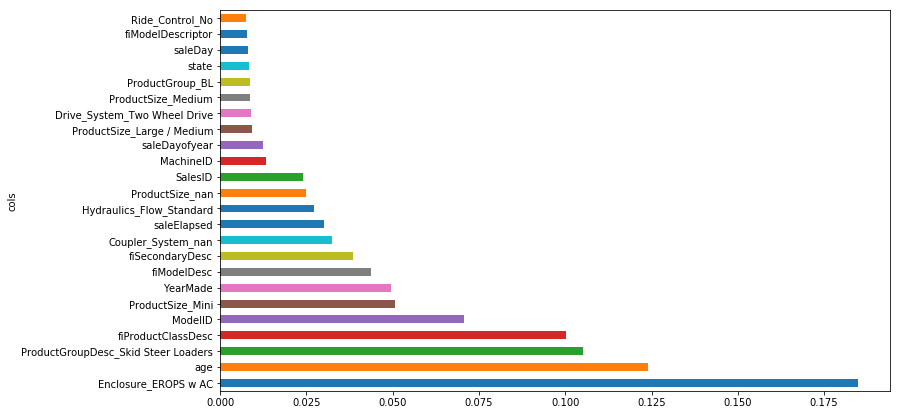

In [28]:
X_train, X_valid = split_vals(X_imp_col, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, X_imp_col));

As we see, `Age` turns out to be one of the most important feature, in fact the second most important feature!

Finally, we know that Random Forests are bad at extrapolation as their predictions are effectively the mean of similar rows. So, to improve the accuracy of out model, we need to find features which have a strong temporal component. This means that we need to find those features which are significantly different in training and validation sets, and would thus be impossible for our random forest model to predict.

For this, we add a new column to our data (training and validation set combined minus the indepentant variable) which has a value of 0 for the training rows and a value of 1 for validation rows. 

In [29]:
df_ext = X_imp_col.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x1, y1, nas = proc_df(df_ext, 'is_valid')

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x1, y1);
m.oob_score_

0.9999975070115301

Since the model is able to perfectly distinguish between the training and validation rows, we must be having features which have a strong temporal component, which will be revealed by looking at feature importances

In [31]:
fi = rf_feat_importance(m, x1); fi[:10]

,cols,imp
9,SalesID,0.834749
4,saleElapsed,0.107472
12,MachineID,0.052843
19,saleDayofyear,0.001507
1,YearMade,0.001268
2,ModelID,0.000813
0,Enclosure_EROPS w AC,0.000506
23,age,0.000376
8,fiModelDesc,0.000289
17,Drive_System_Two Wheel Drive,0.000059


We use the pandas' describe method to confirm our hypothesis that the values of the top 3 column in feature importance table are much different in training and validation sets

In [32]:
feats=['SalesID', 'saleElapsed', 'MachineID']
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,389125.000000,389125.000000
mean,1800.452485,10847.971323,1206.796148
std,595.627288,1803.912915,430.850552
min,1139.246000,6009.984000,0.000000
25%,1413.348000,9666.432000,1087.016000
50%,1632.093000,11346.048000,1273.859000
75%,2210.453000,12341.376000,1458.661000
max,4364.741000,13251.168000,2313.821000


In [33]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,12000.000000,12000.000000
mean,5786.967651,13066.092864,1578.049709
std,836.899608,249.780840,589.497173
min,4364.751000,11745.216000,0.830000
25%,4408.580750,13092.192000,1271.225250
50%,6272.538500,13160.448000,1825.317000
75%,6291.792250,13214.016000,1907.858000
max,6333.342000,13252.032000,2486.330000


We drop the top 3 columns which have the largest temporal component to see which of the rest of the columns have a time-series component

In [34]:
x1.drop(feats, axis=1, inplace=True)

In [35]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x1, y1);
m.oob_score_

0.9806120286693674

In [36]:
fi = rf_feat_importance(m, x1); fi[:10]

,cols,imp
20,age,0.240719
1,YearMade,0.201701
16,saleDayofyear,0.168138
2,ModelID,0.073641
18,saleDay,0.073147
15,state,0.064530
7,fiModelDesc,0.057896
3,fiProductClassDesc,0.035072
6,fiSecondaryDesc,0.021902
0,Enclosure_EROPS w AC,0.018266


In [37]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

Now, we will remove the top 6 six features which have a strong time series component one at a time to see how their removal impacts the accuracy of our model

In [38]:
X_train, X_valid = split_vals(X_imp_col, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12661178138077894, 0.23484894647102253, 0.9664970488213644, 0.9015025002490373, 0.9065297529551399]


In [39]:
for f in feats:
    X_sub = X_imp_col.drop(f, axis=1)
    X_train, X_valid = split_vals(X_sub, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.13063620257902359, 0.23144750329614555, 0.9643333827549498, 0.9043350223217349, 0.9064316562209204]
saleElapsed
[0.1329473767156142, 0.24199609586949497, 0.9630602143691438, 0.8954161336714389, 0.9009992783428042]
MachineID
[0.13049497605871455, 0.233482048035291, 0.9644104570948098, 0.9026457394853904, 0.9076129673240549]
age
[0.12789739218605858, 0.23458876056198438, 0.965813219402191, 0.9017206273952664, 0.9061645977877687]
YearMade
[0.12786393842484942, 0.23733279829581103, 0.9658311013433467, 0.8994079882588358, 0.9061215446881916]
saleDayofyear
[0.13083537374047882, 0.23346075647302972, 0.9642245434481393, 0.9026634944246217, 0.905250242714321]


We finally remove the columns `Sales ID, MachineID and saleDayofyear` and check the accuracy of our model

In [40]:
X_sub = X_imp_col.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(X_sub, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.14136571993409805, 0.2265668843474449, 0.9582339845682597, 0.9083271276976936, 0.9071039392284108]


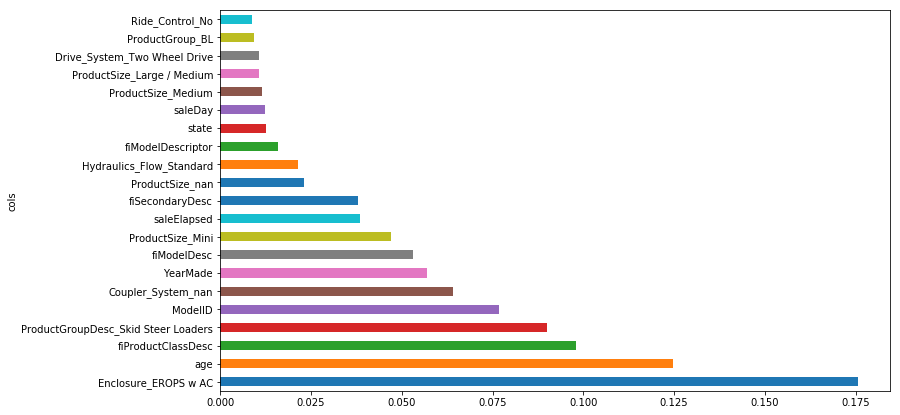

In [41]:
plot_fi(rf_feat_importance(m, X_train));

## The final model

In [42]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 10min 48s, sys: 3.97 s, total: 10min 52s
Wall time: 1min 32s
[0.08246474868802847, 0.2200213685163183, 0.9857874663585101, 0.913547471991879, 0.9123327766016925]
